# **Chap 9：对抗和生成**

In [2]:
import tensorflow as tf
import numpy as np
from typing import Callable
from matplotlib import pyplot as plt
from source.code import utils
from source.code import ch9

2023-11-06 11:15:31.137139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 11:15:31.281871: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 11:15:31.324653: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 11:15:32.092276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
utils.gpu_limitation_config(memory=30,device=2)

## **9.2 快速梯度符号方法 FGSM**

Szegedy 等人发现，一些**机器学习模型（包括表现最好的神经网络），对于精心设计的对抗样本（对抗样本在原始样本的基础上做了微小的扰动，以致于人们完全无法区分它们）会变得非常脆弱**，模型会以**相当高的置信度错误分类**对抗样本
* 更令人惊讶的是，对于**不用种类的模型，使用不同的训练数据集，它们会错误分类同一个对抗样本**，对抗样本揭示了目前我们所使用的机器学习算法中存在的基本型盲点
* 对抗样本的出现意味着，目前我们的机器学习模型，**即使能在测试集上取得非常的表现，也没有真正学会决定样本标签背后的真实概念**，相反，它们**只能在自然产生的数据上工作良好，当处理训练数据分布中不常见的状况时表现糟糕**
* 起初人们推测**对抗样本的出现，是因为深度模型的极度非线性特性，以及缺少充分的模型平均、模型正则化导致的过拟合**，但 Goodfellow 指出**高维空间中的线性行为就足以创建出对抗样本**，基于该观点，Goodfellow 等人提出了**创造对抗样本的快速梯度符号方法 FGSM**
* 此外，**使用对抗式训练能作为一种额外的正则化手段**，相比 Dropout，预训练和模型平均是更有效的，增加模型应对对抗攻击的能力的方法

如何理解对抗样本、创造对抗样本、提升模型和算法以更好地防御对抗攻击非常重要

----

### **9.2.1 从高维线性理解对抗样本**

在许多实际问题中，**样本的每个输入特征的精度可能有有限的**，例如数字图像每个像素只使用 8bit 进行表示（0~255），因此像素会忽略掉所有精度低于 1/255 的信息. 当**精度受限时，如果对样本 $\tilde{x} = x + \eta$ 的扰动 $\eta$ 充分小，小于特征的精度**，那么分类器将无法对不同的输入 $x,\tilde{x}$ 做出不同的判断

形式化建模上述问题，对于可良好分类的问题，我们希望**只要扰动 $\|\eta\|_{\infty} < \epsilon$ 充分小，分类器应该将 $x$ 和 $\tilde{x} = x + \eta$ 预测为相同的类**，$\epsilon > 0$ 是一个充分小的数，使得收集数据的传感器，或者保存数据的文件都达不到这个精度

现在考虑一个权重向量 $w$，以及一个对抗样本 $\tilde{x} = x + \eta$，考虑它们的点积：
$$
w^T\tilde{x} = w^Tx + w^T\eta
$$

对抗样本带来的扰动使点积的结果增加了 $w^T\eta$，我们可以**将 $\eta$ 设为 $\eta = \text{sign}(w)$ 以最大化增量 $w^T\eta$**，如果权重向量 $w$ 元素的平均大小是 $m$，特征维度为 $n$，则增量最大值为 $\epsilon m n$
* 注意到，虽然 $\|\eta\|_{\infty}$ 不会随着维度 $n$ 的增加而增长，但 **$\eta$ 带来的点积扰动 $\epsilon m n$ 会随着特征维度 $n$ 线性增长**
* 因此**对于高维问题，我们可以对输入进行许多无穷小的改变，但它们加起来却是对输出的一个大的改变**

上述事实表明，**即使是最简单的线性模型，只要输入维度充分大，也可以构造相应的对抗样本**，新的解释相比之前关于对抗性样本是由于模型的非线性性质和过拟合导致的，更加简单直观，也说明了为什么大部分模型都存在对抗样本

从上述的对抗样本的线性视角出发，可以非常自然地引出一种生存对抗样本的快速方法. 虽然神经网络拥有非线形激活函数，但我们**假设神经网络过于线形，以致于无法抵御上述讨论中的线性对抗置换攻击**
* 事实上，**很多神经网络的基本算子，例如矩阵乘法，ReLU 激活函数在大部分数值范围内的行为都是线性的**，即使是使用 Sigmoid 这种非线形激活函数，**神经元的值大部分时间也都处在 S 型曲线的非饱和状态（即处在 S 型曲线的中间，而非两端）**，这使得 Sigmoid 激活函数的行为也是近似线形的，因此这里做出的假设有一定的合理性
* 在上述假设下，对线形模型 $w^T x$ 的这种简单、解析可微的扰动攻击，**直觉上对神经网络也依然有效**

现在设 $\boldsymbol{\theta} $ 是模型的参数，$\mathbf{x}$ 是输入特征，$y$ 是特征 $\mathbf{x}$ 对应的标签，$J(\boldsymbol{\theta}, \mathbf{x}, y)$ 是训练模型时使用的目标函数，我们将目标函数在当前参数值 $\boldsymbol{\theta}$ 处**线性化**，得到**最优的 $\epsilon-$ 受限的最大范数扰动** $\boldsymbol{\eta}$ 为：
$$
\boldsymbol{\eta} = \epsilon\cdot \text{sign}\left(\nabla_{\mathbf{x}} J(\boldsymbol{\theta}, \mathbf{x}, y)\right)
$$

基于上述扰动的对抗样本生成方法 $\tilde{\mathbf{x}} = \mathbf{x} + \boldsymbol{\eta}$ 称为**快速梯度符号方法 FGSM**，其中梯度 $\nabla_{\mathbf{x}}$ 可以使用**深度学习框架中的反向传播快速得到**，下图展示了 FGSM 的攻击效果，原始的 Softmax 分类器认为 $\mathbf{x}$ 是熊猫的概率为 57.7%，在原始输入的基础上施加一个 $\epsilon = 0.007$ 的扰动，分类器会以高达 99.3% 的置信度错误地将 $\mathbf{x} + \boldsymbol{\eta}$ 认为是长臂猿，而该扰动在人眼看来微不足道

<img src="../source/Chap9/FGSM攻击示意.jpg" width=700 style="display: block; margin-left: auto; margin-right: auto;">

下面，我们以 `MNIST` 数据集为例，搭建一个简单的分类器，并演示 FGSM 生成对抗样本

首先，我们加载 MNIST 数据集，并进行简单的预处理，将像素值转换到 $[0,1]$ 区间内

In [5]:
# 加载 MNIST 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 标准化到 [0,1]，添加通道维度，并转换为 float32
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train[..., tf.newaxis], x_test[..., tf.newaxis]
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


接下来，用 `Sequential` 方法创建一个简单的卷积神经网络

In [6]:
model = tf.keras.models.Sequential([
    # 输入维度
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    # 两层卷积层
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    # 全局平均池化层
    tf.keras.layers.GlobalAveragePooling2D(),
    # 全连接层
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 8)                0         
 lobalAveragePooling2D)                                          
                                                        

2023-11-06 11:17:41.478201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 11:17:42.259796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30000 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


接下来，我们编译模型，并在训练集上训练

In [7]:
# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# 训练模型
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10


2023-11-06 11:17:50.143827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-06 11:17:50.578881: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


938/938 [==============================] - 7s 5ms/step - loss: 1.1607 - accuracy: 0.5984 - val_loss: 0.6839 - val_accuracy: 0.7725
Epoch 2/10
938/938 [==============================] - 5s 5ms/step - loss: 0.6032 - accuracy: 0.8021 - val_loss: 0.4971 - val_accuracy: 0.8387
Epoch 3/10
938/938 [==============================] - 4s 5ms/step - loss: 0.5142 - accuracy: 0.8315 - val_loss: 0.4592 - val_accuracy: 0.8482
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.4785 - accuracy: 0.8437 - val_loss: 0.4615 - val_accuracy: 0.8524
Epoch 5/10
938/938 [==============================] - 4s 5ms/step - loss: 0.4543 - accuracy: 0.8529 - val_loss: 0.4412 - val_accuracy: 0.8580
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.4369 - accuracy: 0.8576 - val_loss: 0.3989 - val_accuracy: 0.8714
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.4212 - accuracy: 0.8643 - val_loss: 0.4051 - val_accuracy: 0.8713
Epoch 8/10
938/93

下面的函数 `generate_FGSM_adversarial_perturbation()` 用于生成 FGSM 的对抗扰动 $\boldsymbol{\eta}$，函数已经写入 `../source/code/ch9.py`

In [8]:
def generate_FGSM_adversarial_perturbation(
    model : tf.keras.Model, x : tf.Tensor, y : tf.Tensor, loss_func : Callable, epsilon : float=0.01):
    """
    ### 生成 FGSM 对抗扰动
    Parameters
    ----------
    model : tf.keras.Model
        训练好的神经网络模型
    x : tf.Tensor
        输入样本，形状 (batch_size, height, width, channels)
    y : tf.Tensor
        输入样本的真实标签，形状 (batch_size,)
    loss_func : Callable
        损失函数 loss_func(y_true, y_pred)
    epsilon : float, default = 0.01
        扰动系数, 默认值为 0.01
    """

    # 计算梯度 \nabla_x J(\theta, x, y)
    x = tf.Variable(x) # 转换为 tf.Variable 类型
    with tf.GradientTape() as tape:
        y_hat = model(x, training=False) # 前向传播
        loss = loss_func(y, y_hat) # 计算损失
    
    # 反向传播，计算梯度
    grad = tape.gradient(loss, x) # 形状 (batch_size, height, width, channels)

    # 计算扰动 eta = epsilon * sign(\nabla_x J(\theta, x, y))
    eta = epsilon * tf.sign(grad)
    # 生成对抗样本
    x_adv = x + eta
    
    return eta, x_adv

我们来生成一些对抗样本，并通过 `show_adversarial_examples()` 来展示 FGSM 攻击的效果

In [9]:
def show_adversarial_examples(
    model : tf.keras.Model, x : tf.Tensor, eta : tf.Tensor, x_adv : tf.Tensor):
    """
    ### 展示对抗样本攻击
    Parameters
    ----------
    model : tf.keras.Model
        训练好的神经网络模型
    x : tf.Tensor
        输入样本，形状 (batch_size, height, width, channels)
    eta : tf.Tensor
        对抗扰动，形状 (batch_size, height, width, channels)
    x_adv : tf.Tensor
        对抗样本，形状 (batch_size, height, width, channels)
    """
    def make_prediction(x):
        y_hat_dist = model(x, training=False) # 获得概率分布，形状 (batch_size, num_classes)
        probs = tf.reduce_max(y_hat_dist, axis=-1) # 预测类的概率，形状 (batch_size,)
        y_hat = tf.argmax(y_hat_dist, axis=-1) # 获得预测类，形状 (batch_size,)
        return y_hat, probs
    
    y_hat, probs = make_prediction(x) # 计算原始样本的预测概率
    y_hat_adv, probs_adv = make_prediction(x_adv) # 计算对抗样本的预测概率
    y_hat_eta, probs_eta = make_prediction(eta) # 计算扰动 eta 的预测概率

    # 展示对抗样本攻击
    nrow, ncol = x.shape[0], 3
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*2.5, nrow*2.5))
    # 如何 nrow = 1，需要将 axes 转换为二维数组
    if nrow == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i in range(nrow):
        # 原始样本
        axes[i, 0].imshow(x[i], cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Original\npred={y_hat[i]}  prob={probs[i]:.4f}')
        # 扰动 eta
        axes[i, 1].imshow(eta[i], cmap='Reds', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Perturbation\npred={y_hat_eta[i]}  prob={probs_eta[i]:.4f}')
        # 对抗样本
        axes[i, 2].imshow(x_adv[i], cmap='Reds', vmin=0, vmax=1)
        axes[i, 2].set_title(f'Adversarial\npred={y_hat_adv[i]}  prob={probs_adv[i]:.4f}')
    plt.tight_layout()

In [22]:
# 随机从测试集中抽取 n_batch 个样本
n_batch = 5
idx = np.random.randint(0, x_test.shape[0], size=n_batch)
x_batch, y_batch = tf.gather(x_test, idx), tf.gather(y_test, idx)
# 生成对抗样本
epsilon = 0.05
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
eta, x_adv = ch9.generate_FGSM_adversarial_perturbation(model, x_batch, y_batch, loss_func, epsilon)

我们可以观察到，一个微不足道的扰动，对于人们肉眼的识别不会造成任何干扰，却使得模型的预测发生天翻地覆的变化

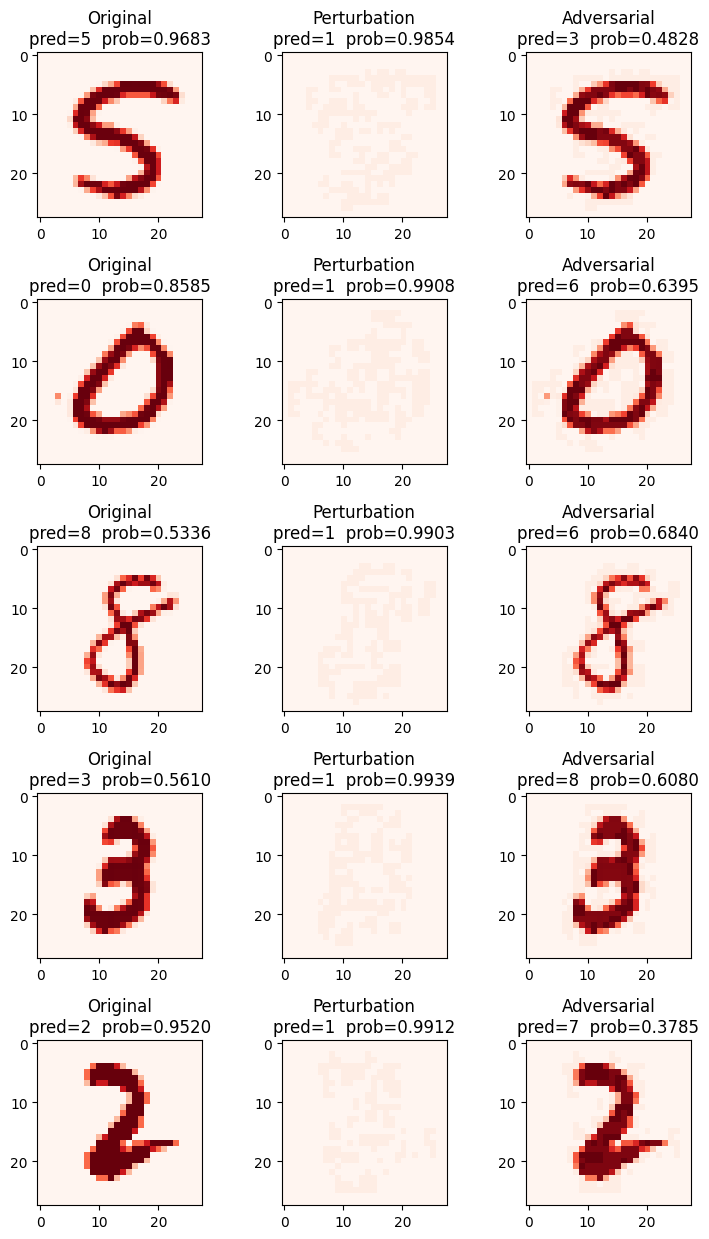

In [23]:
ch9.show_adversarial_examples(model, x_batch, eta, x_adv)

----

### **9.2.2 从权重衰退到对抗训练**

为了更深入理解 FGSM 对抗样本生成，我们考虑一个简单的 Logistic 回归模型，这便于我们清晰地计算 FGSM 的各个变量. 

我们用概率模型 $P(y=1) = \sigma(w^Tx + b)$ 来拟合二分类标签 $y\in\{-1,1\}$，其中 **$\sigma(z)$ 是 Logistic Sigmoid 函数**：
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

记 $z = w^Tx + b$，**训练这个模型时，将使用下面的交叉熵损失函数**，进行梯度下降：
$$
J(w,b,x,y) = \left\{
    \begin{array}{ll}
        -\log{\sigma(z)}, & y = 1\\
        -\log{\left(1 - \sigma(z)\right)}, & y = -1\\
    \end{array}
\right. 
= \zeta(-yz)
$$
其中，$\zeta(s) = \log{\left(1 + \exp(s)\right)}$ 是 **Softplus 函数**，可以验证，当 $y=1$ 时：
$$
\zeta(-yz) = \zeta(-z) = \log{\left(1 + \exp(-z)\right)} = -\log{\frac{1}{1 + \exp(-z)}} = -\log{\sigma(z)}
$$
而当 $y = -1$ 时：
$$
\zeta(-yz) = \zeta(z) = \log{\left(1 + \exp(z)\right)} = -\log{\frac{1}{1 + \exp(z)}} = -\log{\frac{e^{-z}}{e^{-z} + 1}} = -\log{\left(1 - \sigma(z)\right)}
$$

我们可以简单绘制一下 Softplus 函数 $\zeta(s)$ 的图像，它可以**看作是一种“软”的 ReLU 函数**

Text(0.5, 0, '$x$')

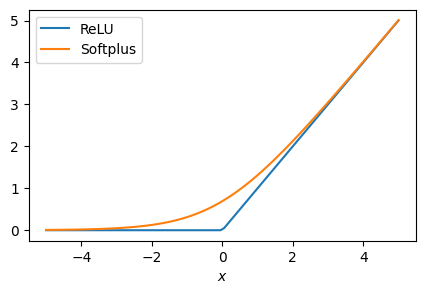

In [8]:
x = tf.linspace(-5, 5, 100)
y_relu = tf.nn.relu(x)
y_softplus = tf.nn.softplus(x)
fig = plt.figure(figsize=(5, 3))
plt.plot(x, y_relu, label='ReLU')
plt.plot(x, y_softplus, label='Softplus')
plt.legend()
plt.xlabel('$x$')

**Softplus 函数的另一个性质是，其导数是 Sigmoid 函数**，即：
$$
\zeta'(s) = \sigma(s)
$$

注意到此时的 FGSM 梯度 $\nabla_x \zeta$ 为：
$$
\frac{\partial \zeta(-yz)}{\partial x} = \frac{-y\exp{(-yz)}}{1 + \exp{(-yz)}} w = -y\cdot \sigma(-yz)w = -r\cdot w
$$

忽略掉前面的系数，梯度符号为 $-\text{sign}(w)$，而 $w^T \text{sign}(w) = \sum_i |w_i| = \|w\|_1$，我们**将对抗性梯度扰动加入到** $z = w^T x+ b$，**让模型在最困难的样本 $\tilde{x} = x + \eta$ 上训练，而不是在 $x$ 本身**，此时优化目标函数变为：
$$
\zeta\left(-y(w^T\tilde{x} + b )\right) = \zeta\left(-y(w^T(x - \epsilon\cdot \text{sign}(w)) + b )\right) = \zeta\left(y(\epsilon\|w\|_1 - w^Tx - b )\right)
$$

**上式的形式与 $L_1$ 正则化非常相似**，但它们也有一些重要的区别，注意 **$L_1$ 正则化的惩罚项添加在激活值的外面**：
$$
\zeta\left(-y(w^T x + b)\right) + \epsilon\|w\|_1
$$

而对抗性梯度扰动的惩罚项添加到激活值内部，**这意味着如果模型在学习过程中能够做出充分自信的预测（从而 $\zeta$ 趋于饱和），惩罚项的效果最终会开始消失**
* 因为**当 $\zeta$ 趋于饱和时**：
    * $w^Tx + b$ 充分大（对应于 $y=1$，趋于正无穷方向）
    * 或者 $w^Tx + b$ 充分小（对应于 $y=-1$，趋于负无穷方向）
    
    $\zeta(-yz)$ 中 $-yz$ 都趋于负无穷方向，**此时 $\epsilon\|w\|_1$ 一项对 $\zeta\left( y(\epsilon\|w\|_1 - w^Tx - b) \right)$ 的影响在数值上微不足道**，所以**惩罚项效果消失**
* 这我们**并不能保证上述情况发生**，在**训练不足的情况下，对抗性训练只会加剧训练不足**
* 而如果回到 $L_1$ 正则化的视角，**$L_1$ 正则化成为了一种“更坏的情况”**，因为**即使模型已经学习得到了良好的决策边界，惩罚项也不会随之消失**，只要系数 $w$ 不为零，惩罚就一直存在

当我们从二分类 Logistic 回归转向多分类 Softmax 回归时，$L_1$ 正则化权重衰退的影响会变得更悲观，因为这种正则化将**对 Softmax 的每个输出的扰动视为独立的**，而事实上**找到一个单一的 $\eta$，使其与所有类别的权重向量一致不太可能**
* 在带有多个隐藏单元的神经网络中，权重衰退会更容易高估扰动 $\eta$ 可能带来的破坏，**由于 $L_1$ 权重衰退高估攻击者能造成的伤害，在训练时我们必须使用一个非常小的 $L_1$ 正则化系数**
* 如果 $L_1$ 正则化系数设置过大，会导致模型训练欠拟合，**而一个充分小的 $L_1$ 正则化系数能取得成功的训练，但同时又失去了正则化的意义**

现在，对于深度神经网络，**基于 FGSM，我们可以构造一种对抗性目标函数**，以获得有效的正则化效果：
$$
\tilde{J}(\boldsymbol{\theta},\mathbf{x},y) = \alpha J(\boldsymbol{\theta},\mathbf{x},y) + (1 - \alpha) J\left(\boldsymbol{\theta},\mathbf{x} + \epsilon\cdot \text{sign}(\nabla_x J(\boldsymbol{\theta},\mathbf{x},y)),y\right)
$$

其中，**$\alpha \in [0,1]$ 是权重系数用于平衡原始的损失函数和 FGSM 对抗性损失函数**
* 这**可以视作不断更新对抗样本，使得它们能够攻击当前版本的模型**
* 对抗性训练也可以与其它正则化手段一起使用，例如 Dropout

**当数据受到攻击者扰动时，对抗性训练过程可以被视为最小化最坏情况下的误差**（一种 **Min-Max** 优化）
* 这可以被解释为**学习玩对抗性游戏**，或者在输入中添加了来自 $U(-\epsilon, \epsilon)$ 的噪声的情况下，**最小化噪声样本的期望损失的上界**
* 对抗性训练也**可以被视为一种主动学习的形式**，模型在新创建的样本点上贴标签，并将它们纳入学习样本中

下面我们思考**为什么对抗性样本具有泛化性**？前文介绍过，**基于某一个模型构造出的对抗样本，通常同时能够误导其他模型，即使这些模型拥有完全不同的架构、或者在不同的训练集上训练得到**. 显然，基于模型的极度非线性和过拟合不能解释这种现象. 
* 如果从有理数之于实数的角度考虑，那么对抗样本几乎处处存在，但仅存在于特征空间中一些非常精确的位置

**在 FGSM 的线性视角下，对抗样本则会存在于广泛的子空间中**，只要对样本 $\mathbf{x}$ 扰动的方向 $\boldsymbol{\eta}$ 具有与损失函数的梯度 $\nabla_x$ 正的点积，并且扰动的程度 $\epsilon$ 足够大，就一定能产生对抗样本. 如果以 Softmax 分类为例，我们**考虑最后输出层多分类的 Logits**，注意到，模型的预测类别 $\hat{c}$ 等于：
$$
\hat{c} = \argmax_{c} \hat{\mathbb{P}}(y = c) =  \argmax_{c} \text{logits}_c
$$

下图展示了对于某个样本（真实类别 $c = 4$），对其进行 FGSM 攻击，Softmax 层的 logits 随着 $\epsilon$ 的变化情况，从图中可以观察到：
* **对抗样本（即被模型错误分类的情形）出现在 FGSM 定义的关于 $\epsilon$ 的一维子空间的连续区域**， 而不是一个有限的集合内
* 只要我们朝着正确的方向前进，几乎任何足够大的 $\epsilon$ 都能可靠地生成对抗性样本，相反，**正确的分类只出现在正常数据分布中，样本 $x$ 的一个细小流形上**
* 我们可以看到，每个类别的 logits 与 $\epsilon$ 呈现明显的分段线性特征，并且**错误的分类在 $epsilon$ 的一个宽泛的区域内是稳定的**
* 这也**部分解释了为什么对抗样本如此丰富，并且利用某一个分类器定义的对抗样本被其他分类器错误分类的先验概率很高**

<img src="../source/Chap9/对抗样本泛化性质的探索.jpg" width=600 style="display: block; margin-left: auto; margin-right: auto;">

----

### **9.2.3 梯度下降视角下的 FGSM 和指定类别攻击**

我们从梯度下降和优化的视角上理解 FGSM 的行为，我们仍然**用 $J(\boldsymbol{\theta}, \mathbf{x}, y)$ 表示模型训练所使用的损失函数**（例如多分类的交叉熵损失），经过模型在训练数据集上的充分调整后，假设模型参数 $\boldsymbol{\theta} = \boldsymbol{\theta}^*$ 固定不变，现在我们**将输入特征 $\mathbf{x}$ 视为优化目标的参数**

在固定模型参数时，为了极小化 $J(\boldsymbol{\theta}^*, \mathbf{x}, y)$，我们需要让 $\mathbf{x}$ 基于其负梯度来更新：
$$
\mathbf{x}^* = \mathbf{x} - \epsilon\cdot \nabla_\mathbf{x} J(\boldsymbol{\theta}^*, \mathbf{x}, y)
$$

对于给定的标签 $y$，方向 $-\nabla_{\mathbf{x}} J(\boldsymbol{\theta}^*, \mathbf{x}, y)$ 是让损失函数减小的方向
* 损失函数的值越小，模型预测结果为 $y$ 的可能性就越大
* **损失函数的值越大，模型预测结果为 $y$ 的可能性就越小，就容易产生错误的预测**

因此，FGSM 使用让损失函数值增大的方向 $\nabla_\mathbf{x} \nabla J(\boldsymbol{\theta}^*, \mathbf{x}, y)$ 来更新 $\mathbf{x}$，但张量 $\nabla_\mathbf{x} \nabla J(\boldsymbol{\theta}^*, \mathbf{x}, y)$ **每个分量元素的大小各不相同，不利于对样本 $\mathbf{x}$ 的总体扰动程度，因此 FGSM 取正梯度的符号 $\text{sign}\left( \nabla_\mathbf{x} J(\boldsymbol{\theta}^*, \mathbf{x}, y)\right)$**
* 符号函数 $\text{sign}(x)$ 只会把分量的值都限制为 $\{-1, 1\}$，但并不会改变优化的方向
* 前面的**系数 $\epsilon$ 在 FGSM 的视角下是总体的扰动程度，而在优化问题的视角下，就是代表学习率**

那么自然地，如果对于原正确分类标签 $y$，如果我们希望经过扰动后的样本，被分类为指定的类别 $y_{target}$，则只需要优化 $J(\boldsymbol{\theta}^*, \mathbf{x}, y_{target})$ 即可，此时扰动样本的更新公式变为：
$$
\mathbf{x}^* = \mathbf{x} - \epsilon\cdot \text{sign}\left( \nabla_\mathbf{x} J(\boldsymbol{\theta}^*, \mathbf{x}, y_{target})\right)
$$

这种**基于 FGSM 的 Target Class Method 就是让样本特征 $\mathbf{x}$ 朝着指定类别优化目标的负梯度方向前进即可**，为了获得稳定的对抗样本，我们可以仿照迭代优化参数一样，让样本 $\mathbf{x}$ 的更新多迭代几个轮次，下面的函数 `generate_FGSM_target_class_adversarial_perturbation()` 用于生成指定类别的对抗样本，函数已经写入 `../source/code/ch9.py`

In [98]:
def generate_FGSM_target_class_adversarial_perturbation(
    model : tf.keras.Model, x : tf.Tensor, y_target : tf.Tensor, loss_func : Callable, epsilon : float=0.01, Epochs : int=5):
    """
    ### 生成基于 FGSM 的指定类别对抗扰动
    Parameters
    ----------
    model : tf.keras.Model
        训练好的神经网络模型
    x : tf.Tensor
        输入样本，形状 (batch_size, height, width, channels)
    y_target : tf.Tensor
        攻击时指定的类别，形状 (batch_size,)
    loss_func : Callable
        损失函数 loss_func(y_true, y_pred)
    epsilon : float, default = 0.01
        扰动系数, 默认值为 0.01.
    Epochs : int, default = 5
        迭代次数, 默认值为 5.
    """

    x_adv = x
    for i in range(Epochs):
        x_adv = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            y_hat = model(x_adv, training=False) # 前向传播
            loss = loss_func(y_target, y_hat) # 计算损失
        
        # 计算梯度 \nabla_x J(\theta, x, y)
        # 反向传播，计算梯度
        grad = tape.gradient(loss, x_adv) # 形状 (batch_size, height, width, channels)

        # 计算扰动 eta = epsilon * sign(\nabla_x J(\theta, x, y))
        eta = epsilon * tf.sign(grad)
        # 更新对抗样本
        x_adv = x_adv - eta
    
    eta = x - x_adv # 计算扰动 eta
    
    return eta, x_adv

我们来测试一下对抗样本的效果

In [107]:
# 随机从测试集中抽取 n_batch 个样本
n_batch = 5
idx = np.random.randint(0, x_test.shape[0], size=n_batch)
x_batch = tf.gather(x_test, idx)
y_target = tf.constant([1, 2, 3, 4, 5]) # 指定攻击的类别
# 生成对抗样本
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
eta, x_adv = generate_FGSM_target_class_adversarial_perturbation(model, x_batch, y_target, loss_func, epsilon=0.01, Epochs=5)

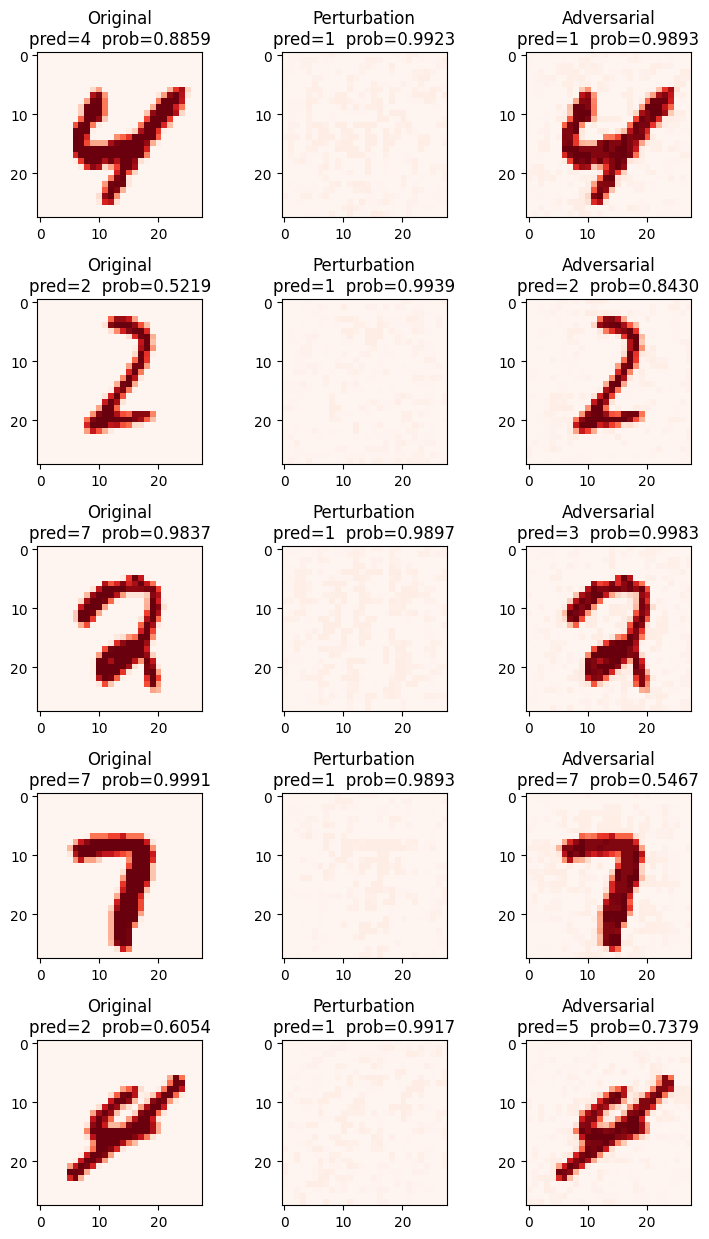

In [108]:
ch9.show_adversarial_examples(model, x_batch, eta, x_adv)

可以看到，经过一个不影响人们肉眼识别的扰动后，对抗样本对模型产生了我们指定类别 `y_target` 的攻击效果

----

### **练习**